<a href="https://colab.research.google.com/github/edielam/Data-Science-Portfolio/blob/master/CryCeleb2023_Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter notebook for the [CryCeleb2023 challenge](https://huggingface.co/spaces/competitions/CryCeleb2023)

## This notebook does the following:
- Download the Cryceleb data from Hugging Face.
- Download a pretrained SpeechBrain model from Hugging Face.
- Compute embeddings.
- Compute similarity scores for pairs of embeddings.
- Compute the equal error rate of the scores and visualize results.
- Produces my_solution.csv that can be uploaded to the competition platform.

### Imports

In [ ]:
%%capture
!pip install speechbrain
import speechbrain as sb
from speechbrain.pretrained import SpeakerRecognition, EncoderClassifier
from speechbrain.dataio.dataio import read_audio
from speechbrain.utils.metric_stats import EER
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

In [ ]:
#@markdown You will need to go to the dataset webpage first to accept the terms

#@markdown You can find your Hugging Face token [here](https://huggingface.co/settings/token)

hf_token = '' #@param {type:"string"}

### Data

In [ ]:
# download data from Huggingface
for file_name in ['dev_pairs.csv', 'test_pairs.csv', 'metadata.csv', 'sample_submission.csv', 'audio.zip']:
  hf_hub_download(
      repo_id="Ubenwa/CryCeleb2023",
      filename=file_name, 
      local_dir=".",
      repo_type="dataset",
      token=hf_token
  )

In [ ]:
%%capture
!unzip "audio.zip"

In [ ]:
# read metadata
metadata = pd.read_csv('metadata.csv', dtype={'baby_id':str, 'chronological_index':str})
dev_metadata = metadata.loc[metadata['split']=='dev'].copy()
# read sample submission
sample_submission = pd.read_csv("sample_submission.csv") # scores are unfiorm random
# read verification pairs
dev_pairs = pd.read_csv("dev_pairs.csv", dtype={'baby_id_B':str, 'baby_id_D':str})
test_pairs = pd.read_csv("test_pairs.csv")

display(metadata.head().style.set_caption("metadata").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))
display(dev_pairs.head().style.set_caption("dev_pairs").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))
display(test_pairs.head().style.set_caption("test_pairs").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))
display(sample_submission.head().style.set_caption("sample_submission").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))

,baby_id,period,duration,split,chronological_index,file_name,file_id
0,0694,B,1.320000,dev,000,audio/dev/0694/B/0694_B_000.wav,0694_B_000
1,0694,B,0.940000,dev,001,audio/dev/0694/B/0694_B_001.wav,0694_B_001
2,0694,B,0.880000,dev,002,audio/dev/0694/B/0694_B_002.wav,0694_B_002
3,0694,B,1.130000,dev,003,audio/dev/0694/B/0694_B_003.wav,0694_B_003
4,0694,B,1.180000,dev,004,audio/dev/0694/B/0694_B_004.wav,0694_B_004


,baby_id_B,baby_id_D,id,label
0,0133,0611,0133B_0611D,0
1,0593,0584,0593B_0584D,0
2,0094,0292,0094B_0292D,0
3,0563,0094,0563B_0094D,0
4,0122,0694,0122B_0694D,0


,baby_id_B,baby_id_D,id
0,anonymous027,anonymous212,anonymous027B_anonymous212D
1,anonymous035,anonymous225,anonymous035B_anonymous225D
2,anonymous029,anonymous288,anonymous029B_anonymous288D
3,anonymous001,anonymous204,anonymous001B_anonymous204D
4,anonymous075,anonymous244,anonymous075B_anonymous244D


,id,score
0,anonymous027B_anonymous212D,0.548814
1,anonymous035B_anonymous225D,0.715189
2,anonymous029B_anonymous288D,0.602763
3,anonymous001B_anonymous204D,0.544883
4,anonymous075B_anonymous244D,0.423655


### Verify Pairs

One way to verify if both pairs come from the same baby is to concatenate all the segments for each pair, compute the embedding of the concatenated cry, and compute the cosine similarity between the embeddings.

In [ ]:
# Speechbrain also has a `SpeakerRecognition` class which can directly compute a similarity,
# however we compute the encodings and the similarities seperately to avoid encoding the same cries many times
encoder = EncoderClassifier.from_hparams(
    source="Ubenwa/ecapa-voxceleb-ft-cryceleb", 
    savedir=f"ecapa-voxceleb-ft-cryceleb", 
    run_opts={"device":"cuda"} #comment out if no GPU available
)

#### Compute Encodings

Change runtime type to GPU if using Colab

In [ ]:
%%time
# read the segments
dev_metadata['cry'] = dev_metadata.apply(lambda row: read_audio(row['file_name']).numpy(), axis=1)
# concatenate all segments for each (baby_id, period) group
cry_dict = pd.DataFrame(dev_metadata.groupby(['baby_id', 'period'])['cry'].agg(lambda x: np.concatenate(x.values)), columns=['cry']).to_dict(orient='index')
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict.items()):
  d['cry_encoded'] = encoder.encode_batch(torch.tensor(d['cry']), normalize=False)

  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


CPU times: user 3.27 s, sys: 411 ms, total: 3.68 s
Wall time: 6.64 s


#### Compute Similarity Between Encodings

In [ ]:
def compute_cosine_similarity_score(row, cry_dict):
  cos = torch.nn.CosineSimilarity(dim=-1)
  similarity_score = cos(
      cry_dict[(row['baby_id_B'], 'B')]['cry_encoded'], 
      cry_dict[(row['baby_id_D'], 'D')]['cry_encoded']
  )
  return similarity_score.item()
dev_pairs['score'] = dev_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict), axis=1)
display(dev_pairs.head())

,baby_id_B,baby_id_D,id,label,score
0,0133,0611,0133B_0611D,0,-0.126186
1,0593,0584,0593B_0584D,0,0.149875
2,0094,0292,0094B_0292D,0,0.146092
3,0563,0094,0563B_0094D,0,0.004630
4,0122,0694,0122B_0694D,0,0.012989


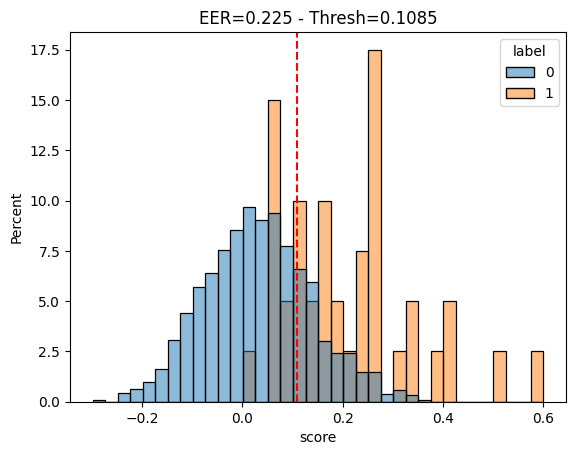

In [ ]:
def compute_eer_and_plot_verification_scores(pairs_df):
  ''' pairs_df must have 'score' and 'label' columns'''
  positive_scores = pairs_df.loc[pairs_df['label']==1]['score'].values
  negative_scores = pairs_df.loc[pairs_df['label']==0]['score'].values
  eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
  ax = sns.histplot(pairs_df, x='score', hue='label', stat='percent', common_norm=False)
  ax.set_title(f'EER={round(eer, 4)} - Thresh={round(threshold, 4)}')
  plt.axvline(x=[threshold], color='red', ls='--');
  return eer, threshold
eer, threshold = compute_eer_and_plot_verification_scores(pairs_df=dev_pairs)

The above plot displays the histogram of scores for +ive (same baby) and -ive (different baby) dev_pairs.\
A perfect verifier would attribute a higher score to all +ive pairs than any -ive pair.\
Your task is to come up with a scoring system which maximizes the separation between the two distributions, as measured by the EER.\
You can change the encoder module, the aggregation of cry segments, the similarity metric, or come up with a completely different process! \
You will be evaluated on the test_pairs.csv, for which ground truth labels are not provided.




Score the test_pairs and submit:



In [ ]:
%%time
test_metadata = metadata.loc[metadata['split']=='test'].copy()
# read the segments
test_metadata['cry'] = test_metadata.apply(lambda row: read_audio(row['file_name']).numpy(), axis=1)
# concatenate all segments for each (baby_id, period) group
cry_dict_test = pd.DataFrame(test_metadata.groupby(['baby_id', 'period'])['cry'].agg(lambda x: np.concatenate(x.values)), columns=['cry']).to_dict(orient='index')
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict_test.items()):
  d['cry_encoded'] = encoder.encode_batch(torch.tensor(d['cry']), normalize=False)

# compute cosine similarity between all pairs
test_pairs['score'] = test_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict_test), axis=1)
display(test_pairs.head())

  0%|          | 0/320 [00:00<?, ?it/s]

,baby_id_B,baby_id_D,id,score
0,anonymous027,anonymous212,anonymous027B_anonymous212D,-0.134164
1,anonymous035,anonymous225,anonymous035B_anonymous225D,0.110196
2,anonymous029,anonymous288,anonymous029B_anonymous288D,-0.007902
3,anonymous001,anonymous204,anonymous001B_anonymous204D,-0.094924
4,anonymous075,anonymous244,anonymous075B_anonymous244D,0.083177


CPU times: user 16 s, sys: 813 ms, total: 16.8 s
Wall time: 17 s


In [ ]:
#submission must match the 'sample_submission.csv' format exactly
my_submission= test_pairs[['id', 'score']]
my_submission.to_csv('my_submission.csv', index=False)
display(my_submission.head())

,id,score
0,anonymous027B_anonymous212D,-0.134164
1,anonymous035B_anonymous225D,0.110196
2,anonymous029B_anonymous288D,-0.007902
3,anonymous001B_anonymous204D,-0.094924
4,anonymous075B_anonymous244D,0.083177
